# Pulling Radio Data out of Thin Air

## Pycon Israel 2018

## Agenda

 - What are radio waves?
 - Hardware radios

## Radio Waves

![static/dipole.gif](static/dipole3.gif)


## RTL-SDR

![rtlsdr.jpg](static/rtlsdr.jpg)

# I/Q Sampling

![static/cosample.png](static/cosample.png)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
modulator_frequency = 4.0
carrier_frequency = 40.0
modulation_index = 1.0
size = 44100.0 * 2

time = np.arange(size) / size
modulator = np.sin(2.0 * np.pi * modulator_frequency * time) * modulation_index
carrier = np.sin(2.0 * np.pi * carrier_frequency * time)

product = np.zeros_like(modulator)
for i, t in enumerate(time):
    product[i] = np.sin(2. * np.pi * (carrier_frequency * t + modulator[i]))

modulator = np.sin(2.0 * np.pi * modulator_frequency * time) * modulation_index
amp = np.zeros_like(modulator)
for i, t in enumerate(time):
    amp[i] = np.sin(2. * np.pi * (carrier_frequency * t * modulator[i]))

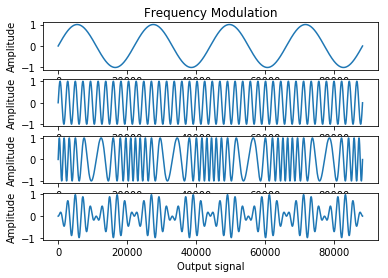

In [5]:
plt.subplot(4, 1, 1)
plt.title('Frequency Modulation')
plt.plot(modulator)
plt.ylabel('Amplitude')
plt.xlabel('Modulator signal')

plt.subplot(4, 1, 2)
plt.plot(carrier)
plt.ylabel('Amplitude')
plt.xlabel('Carrier signal')

plt.subplot(4, 1, 3)
plt.plot(product)
plt.ylabel('Amplitude')
plt.xlabel('Output signal')

plt.subplot(4, 1, 4)
plt.plot(modulator * carrier)
plt.ylabel('Amplitude')
plt.xlabel('Output signal')
plt.show()